# Reading Video Frames Stored as Images

The goal of this example is to show how to use the [readers.sequence](../../operations/nvidia.dali.fn.readers.sequence.html) operator, used to read sequences of frames (video) stored as individual images.

## Preparing the Data

For this example, we will extract some frames from an video file and store them as PNG. We can use DALI's [readers.video](../../operations/nvidia.dali.fn.readers.video.html) to extract the frames, and store them in the directory structure expected by [readers.sequence](../../operations/nvidia.dali.fn.readers.sequence.html).

Let us start by importing the necessary modules, and defining the paths and constants we will use later.

**Note**: `DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [7]:
import os.path
import numpy as np
import shutil
from PIL import Image
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

dali_extra_path = os.environ["DALI_EXTRA_PATH"]
video_filename = os.path.join(
    dali_extra_path, "db/optical_flow/sintel_trailer/sintel_trailer_short.mp4"
)
data_dir = "sequence_reader/samples"
batch_size = 1
sequence_length = 10
initial_prefetch_size = 16
n_iter = 10

Now we are ready to define the DALI pipeline that will read the video file and extract sequences of frames.

In [8]:
@pipeline_def
def video_pipe(filenames):
    video = fn.readers.video(
        device="gpu",
        filenames=filenames,
        sequence_length=sequence_length,
        initial_fill=initial_prefetch_size,
    )
    return video


pipe = video_pipe(
    filenames=video_filename, batch_size=batch_size, num_threads=2, device_id=0
)
pipe.build()

The last step is to run several iterations of the pipeline, to generate several sequences of frames, stored as PNG images.

In [9]:
def save_images(frames, seq_len, directory):
    for j in range(seq_len):
        im = Image.fromarray(frames[j])
        im.save(os.path.join(directory, str(j)) + ".png")


if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
    os.makedirs(data_dir)

for i in range(n_iter):
    pipe_out = pipe.run()
    frames = np.array(pipe_out[0][0].as_cpu())
    label_dir = os.path.join(data_dir, str(i))
    os.makedirs(label_dir)
    save_images(frames, sequence_length, label_dir)

## Frame Sequence Reader

Now we can use [readers.sequence](../../operations/nvidia.dali.fn.readers.sequence.html) to load frame sequences from the directory we generated before.

In [10]:
@pipeline_def
def frame_seq_pipe(path):
    video = fn.readers.sequence(file_root=path, sequence_length=sequence_length)
    return video

And define a function using matplotlib to visualize the results:

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec


def show_sequence(sequence):
    columns = 5
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize=(32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

Finally, we can build and run the pipeline, and show some of the frame sequences produced.

Iteration 0 shape: (10, 720, 1280, 3)
Iteration 1 shape: (10, 720, 1280, 3)
Iteration 2 shape: (10, 720, 1280, 3)
Iteration 3 shape: (10, 720, 1280, 3)
Iteration 4 shape: (10, 720, 1280, 3)
Iteration 5 shape: (10, 720, 1280, 3)
Iteration 6 shape: (10, 720, 1280, 3)
Iteration 7 shape: (10, 720, 1280, 3)
Iteration 8 shape: (10, 720, 1280, 3)
Iteration 9 shape: (10, 720, 1280, 3)


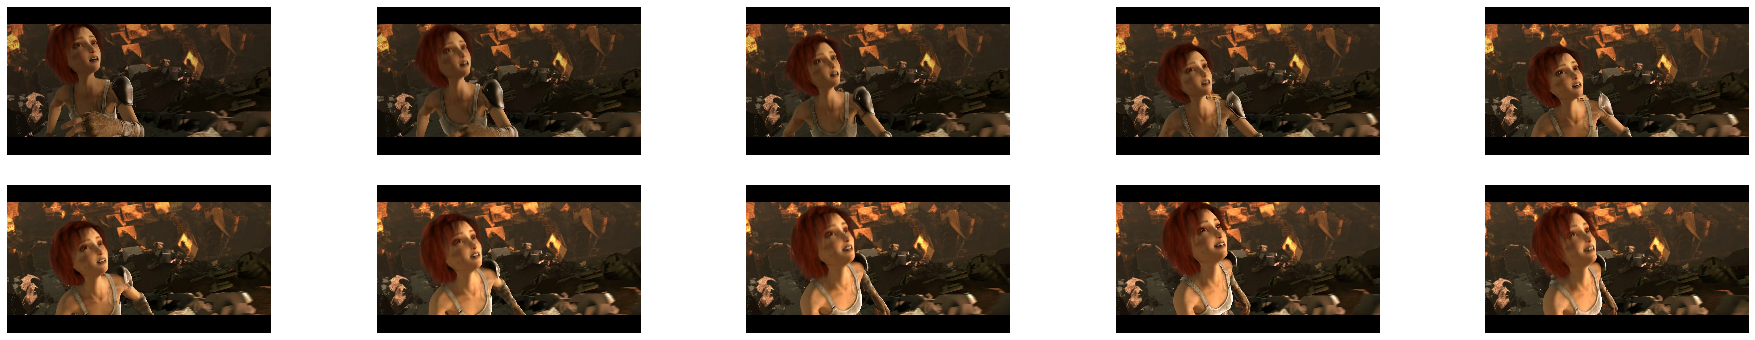

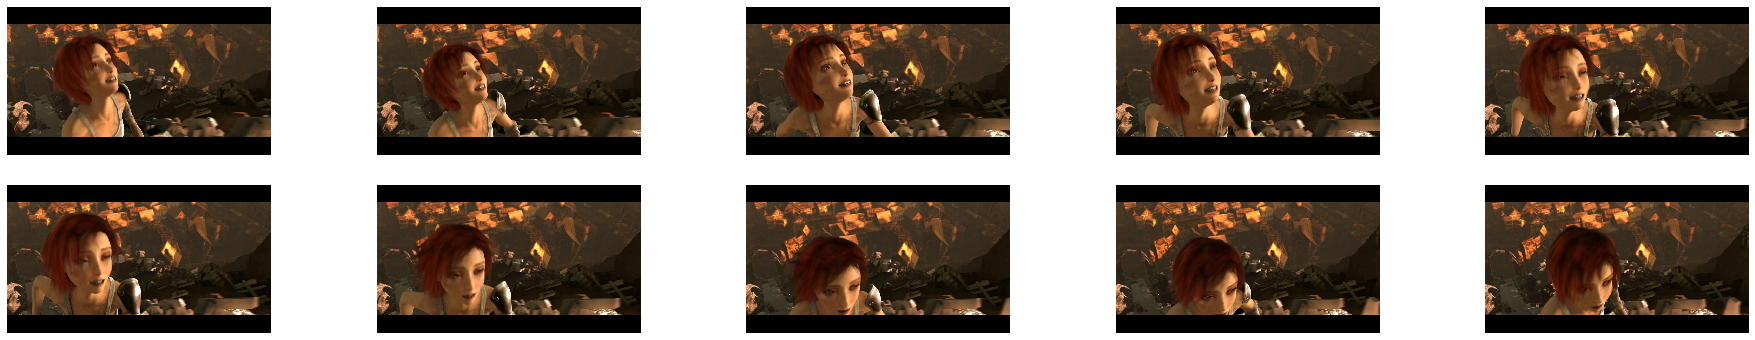

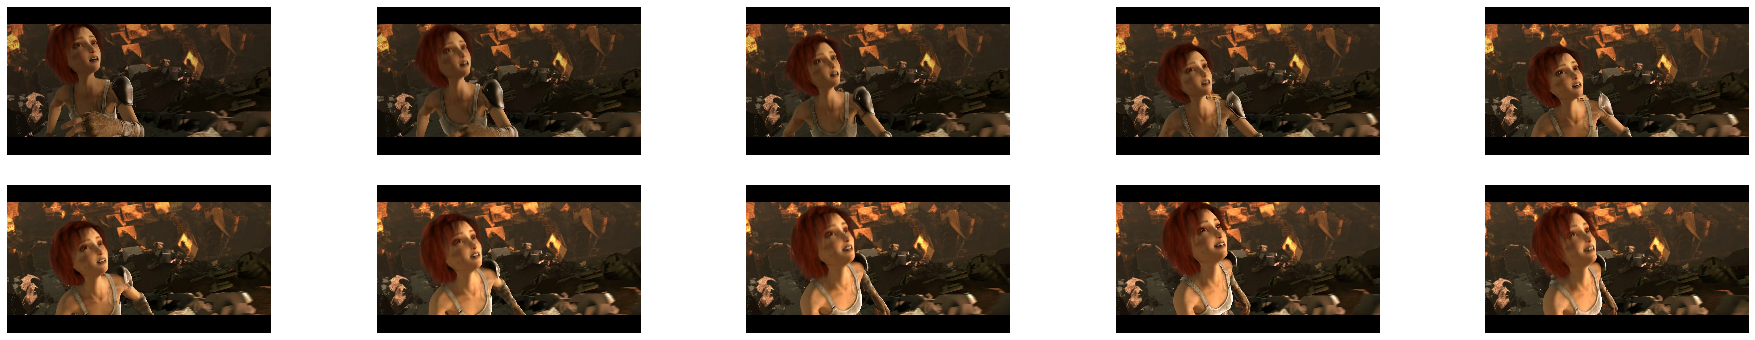

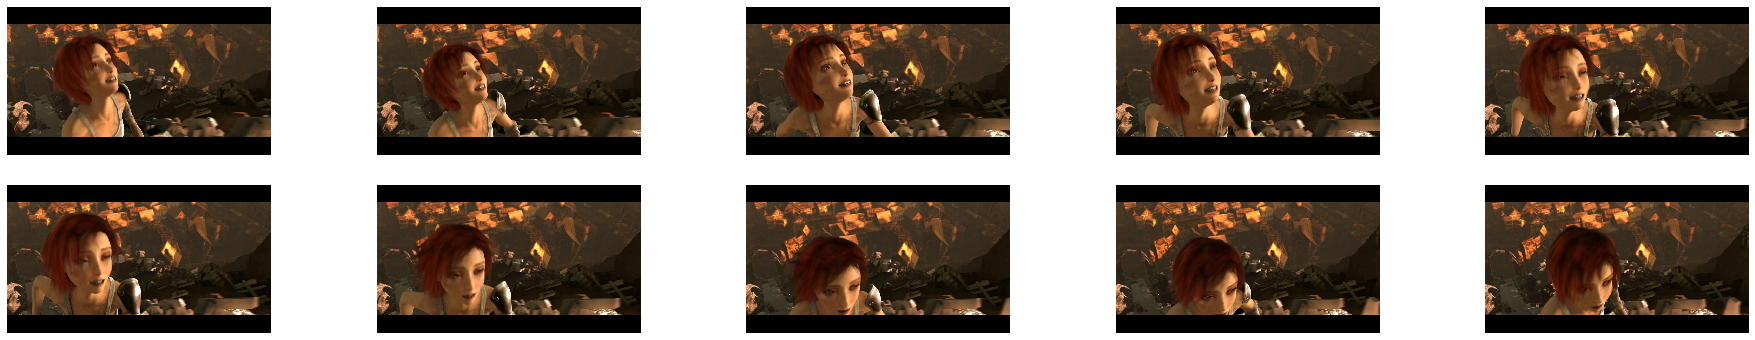

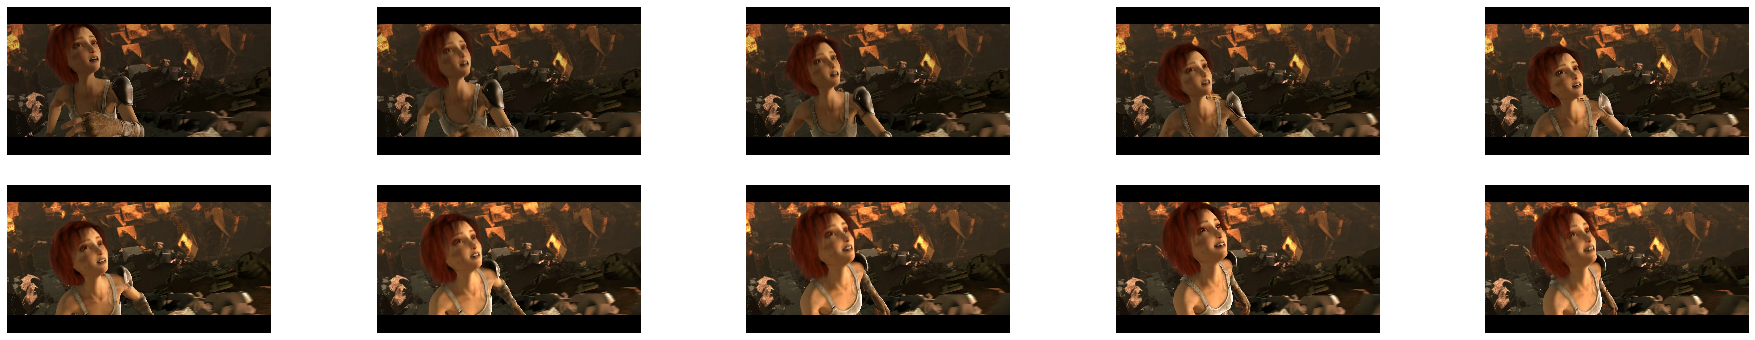

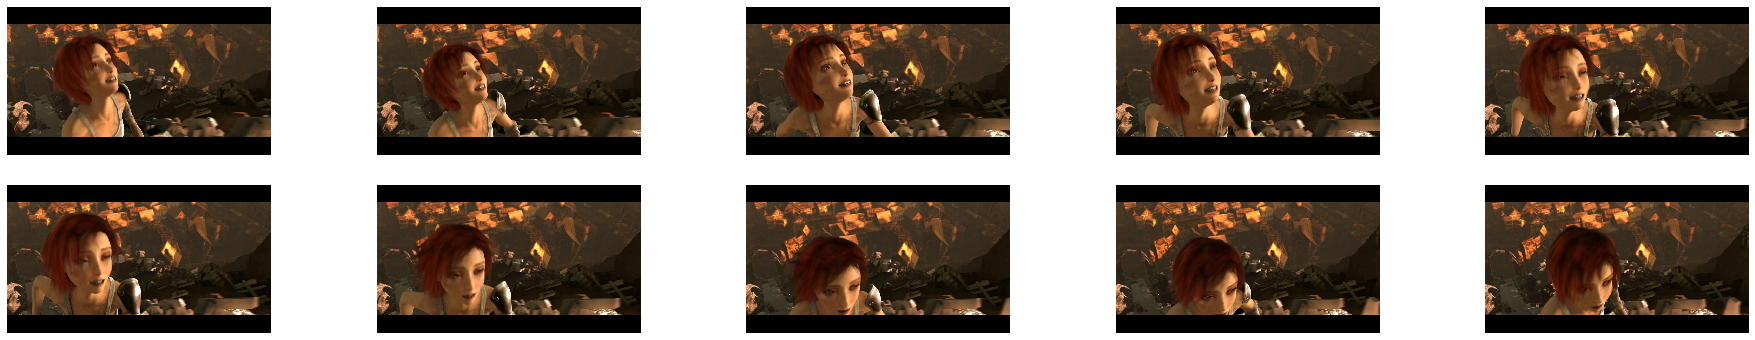

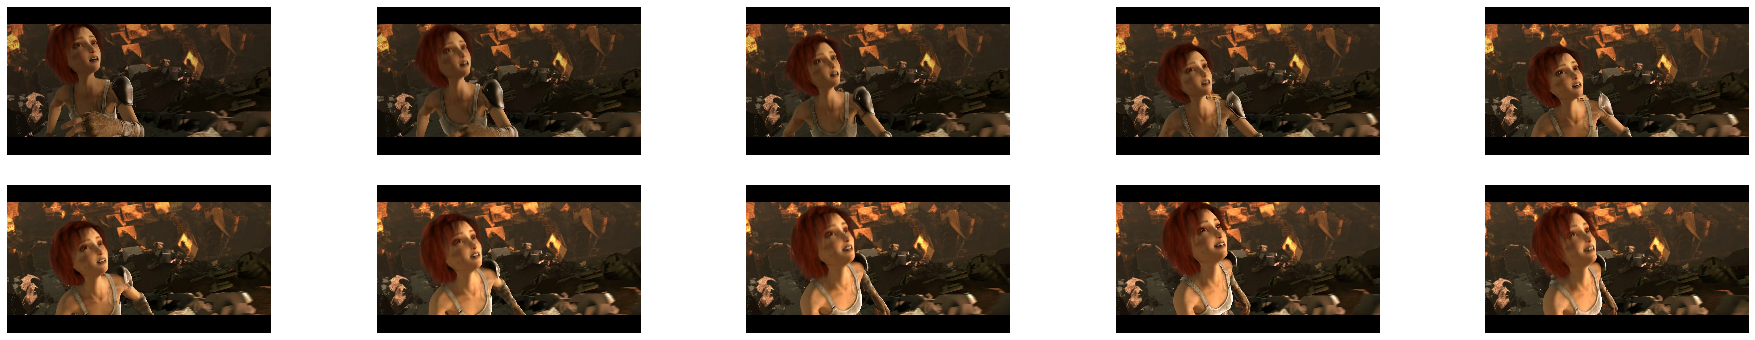

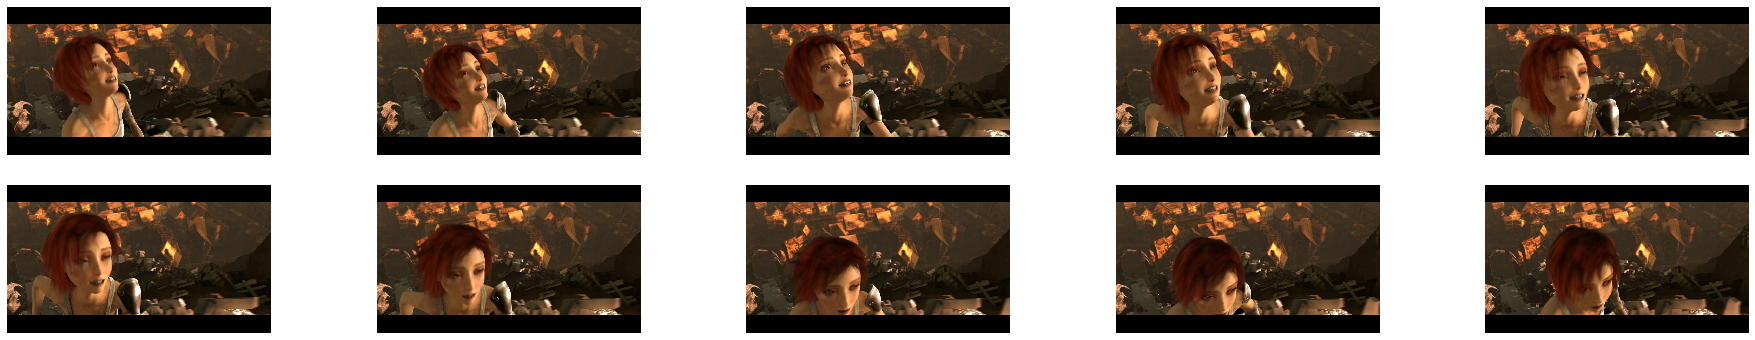

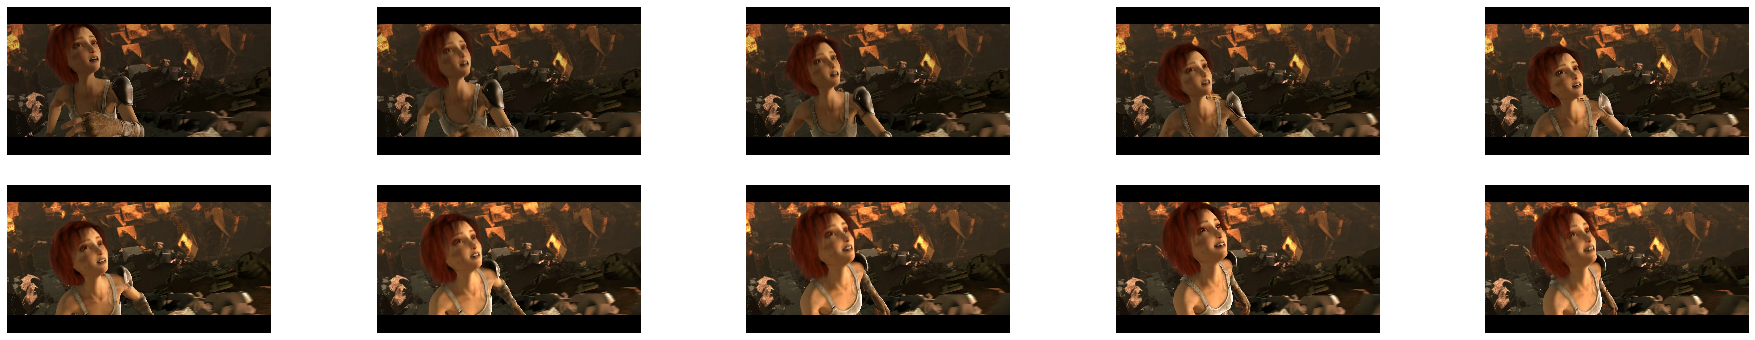

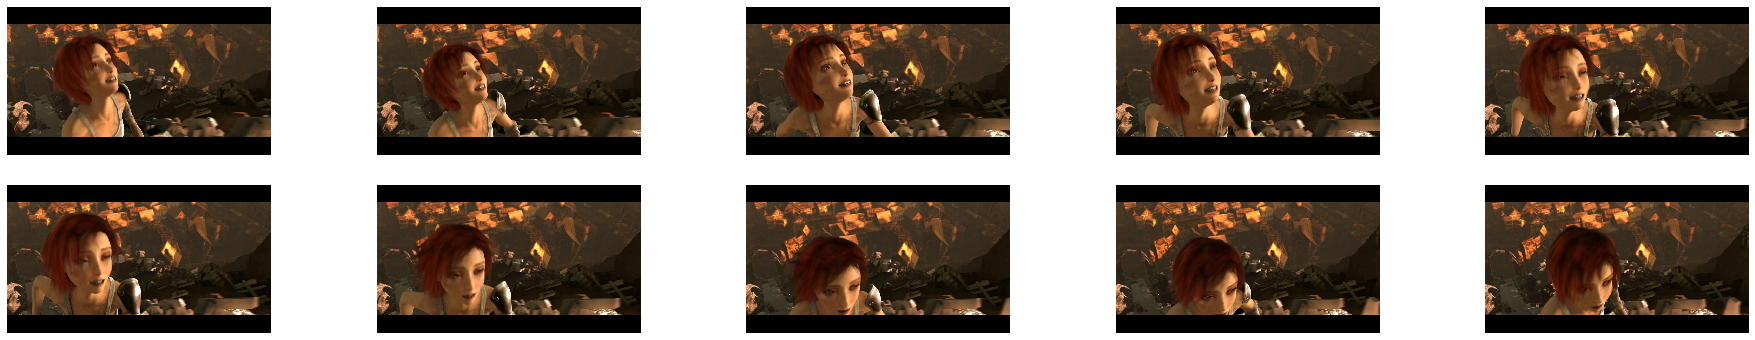

In [12]:
pipe = frame_seq_pipe(
    path=data_dir, batch_size=batch_size, num_threads=1, device_id=0
)
pipe.build()

for i in range(n_iter):
    pipe_out = pipe.run()
    sequences_out = np.array(pipe_out[0][0])
    print(f"Iteration {i} shape: {sequences_out.shape}")
    show_sequence(sequences_out)